## Feature-specific Clustering Experimentation

The majority of this notebook's code is blocks of functions, primarily for reproducibility, consistency, and readability.
The order they were written is not organized, so much as the order they were defined in exploration, cleaned up a bit afterwards.

#### Imports and loading datafiles

In [1]:
import numpy as np
import json
import random
import math
from itertools import permutations

In [2]:
with open("../data/playlist_data.json") as jsonfile:
    playlist_data = json.load(jsonfile)
with open("../data/track_audio_data.json") as jsonfile:
    track_audio_data = json.load(jsonfile)
with open("../data/track_data.json") as jsonfile:
    track_metadata = json.load(jsonfile)

#### Feature Definition and Playlist 

The individual categories of each categorical feature was not something we had the time to explore.

In [4]:
ORD_FEATURES = ["danceability", "energy", "loudness", "speechiness",
            "acousticness", "liveness", "valence", "tempo", "duration_ms"]

CAT_FEATURES = {
    "time_signature": ["0", "1", "3", "4", "5"],
    "key": ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11"],
    "mode": ["0", "1"]
}
# Calculate the (mean) audio summary of a playlist's songs.
def playlist_summary(playlist):
    total_tracks = playlist["num_tracks"]
    audio_summary = dict.fromkeys(ORD_FEATURES, 0)

    # Use the most common label for categorical features.
    cat_appearances = {}
    for feat, values in CAT_FEATURES.items():
        cat_appearances[feat] = {val: 0 for val in values}
    
    for track_num in playlist["tracks"]:
        # Some songs' audio data weren't found when calling Spotify's API.
        # Typically, this seemed to be whenever a song was
        # pulled down from the library, or when the given 'song' was a podcast.
        # Most try/catches and 'is not None' blocks are for this singular reason.
        try:
            track_audio_feats = track_metadata[str(track_num)]
        except KeyError:
            continue

        # Though this is the only that had to be concerned which type of error that was.
        if track_audio_feats is None:
            total_tracks -= 1
            continue

        for feat, val in track_audio_feats.items():
            if feat in CAT_FEATURES:
                cat_appearances[feat][val] += 1
            elif feat in ORD_FEATURES:
                audio_summary[feat] += val
    
    # Average the ordinal features, mode the categorical.
    for feat in ORD_FEATURES:
        audio_summary[feat] = round(audio_summary[feat] / total_tracks, 5)
    for feat in CAT_FEATURES:
        max_appears = "0"
        for val in CAT_FEATURES[feat]:
            if int(cat_appearances[feat][val]) > int(cat_appearances[feat][max_appears]):
                max_appears = val
        audio_summary[feat] = int(max_appears)
    return audio_summary


#### Normalization

Since we're in the business of calculating feature distances, we need to add normalicy of some form.
For our purposes, a simple scaling to [0, 1] sufficed, though for some features--namely,
duration_ms, possibly loudness--a range of [0, 1] probably led to some false closeless.

In [6]:
# Calculate the minimum and maximum of each feature across the entire dataset.
def min_max_feature(tracks, feature):
    max_val = 0.0
    min_val = float('inf')
    for track in tracks:
        if track not in track_audio_data or track_audio_data[track] is None:
            continue
        track_feat = track_audio_data[track][feature]
        if track_feat > max_val:
            max_val = track_feat
        if track_feat < min_val:
            min_val = track_feat
    return min_val, max_val

# Calculate and store the ranges permanently.
feature_mms = {}
tracks = list(track_metadata.keys())
for feature in ORD_FEATURES:
    min_val, max_val = min_max_feature(tracks, feature)
    feature_mms[feature] = {
        "min": min_val,
        "max": max_val,
        "range": round(max_val - min_val)
    }

# Normalize an indivudal feature
def feature_normalizer(value, feature):
    return (value + feature_mms[feature]["min"]) / feature_mms[feature]["range"]

# Normalize the features of a track
def normalize_track(track_audio):
    for feature in track_audio.keys():
        if feature in ORD_FEATURES:
            track_audio[feature] = round(feature_normalizer(track_audio[feature], feature), 5)

# Create a normalized copy of every track in a list (playlist)
def normalize_tracks(track_list):
    normalized = []
    for track in track_list:
        track = track.copy()
        normalize_track(track)
        normalized.append(track)
    return normalized

#### Artist-Playlist Structure
Supporting gathering songs with shared artists in a playlist.

In [7]:
# Determine if a playlist has any songs that share an artist.
def has_common_artist(playlist):
    tracks = playlist["tracks"]
    artists = {}
    for song in tracks:
        artist_name = track_metadata[str(song)]["artist_name"]
        if artist_name in artists:
            return True
        else:
            artists[artist_name] = True
    return False

# Create a dict of sets for artists that have multiple songs in a playlist, and those songs.
def common_songs_per_artist(playlist, threshold=2):
    tracks = playlist["tracks"]
    artists = {}
    for track in tracks:
        if str(track) not in track_audio_data or track_audio_data[str(track)] is None:
            continue
        artist_name = track_metadata[str(track)]["artist_name"]
        if artist_name in artists:
            artists[artist_name].append(track)
        else:
            artists[artist_name] = [track]

    artist_groups = {}
    for artist, group in artists.items():
        if len(group) >= threshold:
            artist_groups[artist] = group
    return artist_groups

{'Disney Studio Chorus': [5233, 5240, 5241], 'Bruce Healey': [5235, 5238]}


#### Distance calculations
In the long term, we would have liked to train regressors on this instead of using L2.

In [9]:
# Calculate the total error between every track in a list, tracking the given features.
def group_feature_error(tracks, feature_filter):
    
    # Normalize the tracks before calculating distances.
    tracks = normalize_tracks(tracks)
    audio_features = {}
    for feature in feature_filter:
        try:
            audio_features[feature] = [track[feature] for track in tracks]
        except KeyError:
            print(tracks)
    
    total_error = 0.0
    # For every feature, get every track's value of that feature, and sum the distance per pair.
    for feature, values in audio_features.items():
        pairs = permutations(values, 2)

        # Naive implementation of categorical feature mismatch. 
        # Should ideally be calculated as something else.
        if feature in CAT_FEATURES:
            for pair in pairs:
                if pair[0] != pair[1]:
                    total_error += 0.125
        else:
            for pair in pairs:
                total_error += (pair[0] - pair[1]) ** 2

    return total_error

# Get the error for every single artist's whole library under the given feature.
def artist_groups_error(artist_groups, feature_filter):
    total_error = 0.0
    for group in artist_groups:
        tracks = [track_audio_data[str(track)] for track in group]
        total_error += group_feature_error(tracks, feature_filter)
    return total_error

#### Global Artist-Song Relation Structures
The structres here are for large-scale precomputation, to save already slow processes some time.

In [11]:
all_playlist_artist_groups = []
for playlist in playlist_data:
    all_playlist_artist_groups.append(list(common_songs_per_artist(playlist).values()))

# Get the set for every artist.
artist_songs_global = {}

# Greedily calculate and *store* the audio per song group to save on large dict lookups later.
global_songs_audio = {}

for track in track_metadata.keys():
    if str(track) not in track_audio_data or track_audio_data[str(track)] is None:
        continue
    artist = track_metadata[track]["artist_name"]
    if artist not in artist_songs_global:
        artist_songs_global[artist] = [int(track)]
        global_songs_audio[artist] = {int(track): track_audio_data[track]}
    else:
        artist_songs_global[artist].append(int(track))
        global_songs_audio[artist][int(track)] = track_audio_data[track]

#### Feature Error 
Calculates how inconsistent each feature is across the global set of playlists.

Rather slow, so the result of our naive distance calculation has been hard-coded as a time-saving measure.s

In [12]:
# SWAP THESE TWO BLOCKS' COMMENTS

# total_error = 0.0
# feature_error = {}
# for feature in ORD_FEATURES:
#     total_error = 0.0
#     for playlist_groups in all_playlist_artist_groups:
#         total_error += artist_groups_error(playlist_groups, [feature])
#     feature_error[feature] = total_error
#
# for feature in CAT_FEATURES.keys():
#     total_error = 0.0
#     for playlist_groups in all_playlist_artist_groups:
#         total_error += artist_groups_error(playlist_groups, [feature])
#     feature_error[feature] = total_error

# Or, to save computational time later (this took 80m though could be sped up significantly through pre-computation): 

feature_error = {
    'danceability': 10003893.968445968,
    'energy': 16634120.566690098,
    'loudness': 1209632.480114869,
    'speechiness': 5083513.644521113,
    'acousticness': 28699650.930126116,
    'liveness': 18470271.84208595,
    'valence': 25369018.24589998,
    'tempo': 8958036.561555453,
    'duration_ms': 106308.21551548693,
    'time_signature': 7260695.5,
    'key': 37147449.0,
    'mode': 16639480.75
}

A quick sort tells us that key, acousticness, liveness, and valence are particularly errorneous.

Perhaps that is an indicator of poor performance, or that many playlists happen to have divergent sub-sets.
Regardless, stash them and use the remaining 7.

In [13]:
sorted_feature_error = {pair[0]: pair[1] for pair in sorted(feature_error.items(), key=lambda x: x[1])}
print(json.dumps(sorted_feature_error, indent=4))

# So the features that perform the best are:
# duration_ms (entirely possible that this is a fault of the normalization)
# loudness (also has a larger range than target area)
# speechiness
# time_signature (perhaps as it's mostly 4)
# tempo
# danceability
# So try using distance calculation recommendations off of these.

{
    "duration_ms": 106308.21551548693,
    "loudness": 1209632.480114869,
    "speechiness": 5083513.644521113,
    "time_signature": 7260695.5,
    "tempo": 8958036.561555453,
    "danceability": 10003893.968445968,
    "energy": 16634120.566690098,
    "mode": 16639480.75,
    "liveness": 18470271.84208595,
    "valence": 25369018.24589998,
    "acousticness": 28699650.930126116,
    "key": 37147449.0
}


#### Recommendation Functions
What this whole thing is actually about.

We tried two different strategies, recommending based on the tracks, and recommending based on the playlist summary.

In [14]:
# Recommend tracks that share an artist with a present song, 
# ranked by how close they are to any of that artist's songs present
def recommend_songs_from_tracks(sample_playlist, distance_metrics):

    # Get the set of artists, and the relevant tracks/audios 
    sample_artists = common_songs_per_artist(sample_playlist, threshold=1)
    artist_tracks = {artist: artist_songs_global[artist] for artist in sample_artists.keys()}
    local_audios = {artist: global_songs_audio[artist] for artist in artist_tracks.keys()}
    track_smallest_dist = {}

    # For every present artist, test all of their tracks against every one of their tracks
    # that is in the playlist.
    # This would be one of the places to experiment the most, going forward.
    for artist, tracks in artist_tracks.items():
        local_tracks = sample_artists[artist]
        for test_track in tracks:
            test_audio = track_audio_data[str(test_track)]
            dist = float('inf')
            for present_track in local_tracks:
                present_audio = local_audios[artist][present_track]
                dist = min(dist, group_feature_error([present_audio, 
                                                      test_audio], 
                                                     distance_metrics))
            track_smallest_dist[test_track] = dist

    # Sort and return the calculated distances.
    closest_tracks = [pair[0] for pair in sorted(track_smallest_dist.items(), key=lambda x: x[1])]
    return closest_tracks

# Recommend tracks that share an artist with a present song, 
# ranked by how close they are to the playlist summary.
def recommend_songs_from_summary(sample_playlist, distance_metrics):
    sample_artists = common_songs_per_artist(sample_playlist, threshold=1)
    artist_tracks = {artist: artist_songs_global[artist] for artist in sample_artists.keys()}
    track_smallest_dist = {}

    # For every present artist, test all of their tracks against the playlist's summary.
    # This would be one of the places to experiment the most, going forward.
    # It's difficult to tell exactly how effective this is.
    playlist_imitation_audio = playlist_summary(sample_playlist)
    for tracks in artist_tracks.values():
        for test_track in tracks:
            test_audio = track_audio_data[str(test_track)]
            dist = group_feature_error([test_audio, playlist_imitation_audio], distance_metrics)
            track_smallest_dist[test_track] = dist

    # Sort and return the calculated distances.
    closest_tracks = [pair[0] for pair in sorted(track_smallest_dist.items(), key=lambda x: x[1])]
    return closest_tracks


#### Masking and Performance
Our attempt at gauging accuracy, using a version of masking protocols we've previously seen.

It's effective for track-based recommendation, but has relative issue with playlist-based.

In [16]:
# Create a masked version of the playlist, removing a sort per artist that has >= 2 songs
def mask_playlist(playlist):
    masked_playlist = dict(playlist)
    masked_playlist['tracks'] = playlist['tracks'].copy()

    # Retain the masked songs as a set of targets.
    targets = {}
    track_artist_groups = common_songs_per_artist(masked_playlist)
    for artist, track_group in track_artist_groups.items():
        target_track = track_group[random.randrange(len(track_group))]
        masked_playlist['tracks'].pop(masked_playlist['tracks'].index(target_track))
        masked_playlist['num_tracks'] -= 1
        if target_track in masked_playlist['tracks']:
            continue
        targets[artist] = target_track

    return masked_playlist, targets

# Create a set of targets for a playlist, and determine each's placement
# in both recommendation lists based on the given distance metrics.
def recommendation_position(playlist, distance_metrics):
    masked_list, targets = mask_playlist(playlist)
    recommendation_summary = recommend_songs_from_summary(masked_list, distance_metrics)
    recommendation_tracks = recommend_songs_from_tracks(masked_list, distance_metrics)
    positions = {"tracks": {}, "summary": {}, "length": len(recommendation_tracks)}
    for song in targets.values():
        positions["summary"][song] = recommendation_summary.index(song)
        positions["tracks"][song] = recommendation_tracks.index(song)
    return positions

# Generate a handful of metrics on the positions of a playlist target recommendations.
def recommendation_performance(playlist, distance_metrics):
    positions = recommendation_position(playlist, distance_metrics)
    track_perf = sorted(list(positions["tracks"].values()))
    summ_perf = sorted(list(positions["summary"].values()))
    performance = {
        "summary": {
            "best": summ_perf[0],
            "worst": summ_perf[-1],
            "median": summ_perf[math.floor((len(summ_perf) - 1) / 2)],
            "out_of": positions["length"]
        },
        "tracks": {
            "best": track_perf[0],
            "worst": track_perf[-1],
            "median": track_perf[math.floor((len(track_perf) - 1) / 2)],
            "out_of": positions["length"]
        }
    }
    return performance

In [28]:
distance_metrics = ["duration_ms", "loudness", "speechiness", "time_signature", "tempo", "danceability", "energy", "mode"]
feature_combos = list(permutations(distance_metrics, 2))
    
combo_performances = {}
index = 100000
span = 250

for combo in feature_combos:
    performances = []
    for playlist in playlist_data[index:index + span]:
        if has_common_artist(playlist):
            try:
                performances.append(recommendation_performance(playlist, combo))
            except IndexError:
                continue
    combo_performances[combo] = performances
    index = index + span

Onto ('duration_ms', 'loudness'). 56.0 remaining
Onto ('duration_ms', 'speechiness'). 55.0 remaining
list index out of range: ('duration_ms', 'speechiness'): {'name': 'disney', 'collaborative': 'false', 'pid': 100266, 'modified_at': 1435708800, 'num_tracks': 21, 'num_albums': 17, 'num_followers': 1, 'tracks': [10455, 10455, 13105, 10459, 22729, 13881, 13110, 7080, 13112, 28337, 13882, 27981, 27974, 43513, 156985, 67369, 28323, 28324, 28325, 123928, 28326], 'num_edits': 2, 'duration_ms': 3991595, 'num_artists': 20}
Onto ('duration_ms', 'time_signature'). 54.0 remaining
list index out of range: ('duration_ms', 'time_signature'): {'name': 'Mondays', 'collaborative': 'false', 'pid': 100642, 'modified_at': 1499040000, 'num_tracks': 30, 'num_albums': 29, 'num_followers': 1, 'tracks': [11166, 799, 281, 819, 296, 37224, 4658, 751, 6744, 7122, 20323, 36639, 8780, 48643, 818, 794, 772, 805, 1031, 11163, 738, 742, 61122, 813, 462699, 806, 52186, 2674, 772, 753], 'num_edits': 3, 'duration_ms': 752

In [18]:
agg_perfs = {}

metrics = ["best", "worst", "median"]
for combo, perfs in combo_performances.items():
    combo_string = f"{combo[0]}-{combo[1]}"
    agg_perfs[combo_string] = {
        "summary": dict.fromkeys(metrics, 0.0), 
        "tracks": dict.fromkeys(metrics, 0.0)
    }
    for performance in perfs:
        for metric in metrics:
            agg_perfs[combo_string]["summary"][metric] += (performance["summary"][metric] / performance["summary"]["out_of"]) / len(perfs)
            agg_perfs[combo_string]["tracks"][metric] += (performance["tracks"][metric] / performance["tracks"]["out_of"]) / len(perfs)


In [19]:
agg_perfs

{'duration_ms-loudness': {'summary': {'best': 0.14406425904168005,
   'worst': 0.7515211531689787,
   'median': 0.37327648047767664},
  'tracks': {'best': 0.10730438292233972,
   'worst': 0.7098301862235646,
   'median': 0.2880828327609508}},
 'duration_ms-speechiness': {'summary': {'best': 0.14997812298617505,
   'worst': 0.7775149899476803,
   'median': 0.39334423862853024},
  'tracks': {'best': 0.11664338815157907,
   'worst': 0.755206486308544,
   'median': 0.3359681209917398}},
 'duration_ms-time_signature': {'summary': {'best': 0.14423875673406283,
   'worst': 0.7196910227879353,
   'median': 0.3792435249241452},
  'tracks': {'best': 0.1405951942489596,
   'worst': 0.7234189783111162,
   'median': 0.3380433978193563}},
 'duration_ms-tempo': {'summary': {'best': 0.18412323113225088,
   'worst': 0.8212417997120122,
   'median': 0.4627600271096026},
  'tracks': {'best': 0.160047187298722,
   'worst': 0.7907518251110678,
   'median': 0.39568408954545337}},
 'duration_ms-danceability'

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Convert the aggregated performance data into multiple dictionaries.
summary_best = {}
summary_worst = {}
summary_median = {}
tracks_best = {}
tracks_median = {}
tracks_worst = {}
features = agg_perfs.keys()

for i in features:
    summary_best[i] = agg_perfs[i]["summary"]["best"]
    summary_worst[i] = agg_perfs[i]["summary"]["worst"]
    summary_median[i] = agg_perfs[i]["summary"]["median"]
    tracks_best[i] = agg_perfs[i]["tracks"]["best"]
    tracks_worst[i] = agg_perfs[i]["tracks"]["worst"]
    tracks_median[i] = agg_perfs[i]["tracks"]["median"]

summary_best = {k: v for k, v in sorted(summary_best.items(), key=lambda item: item[1], reverse=True)}
summary_worst = {k: v for k, v in sorted(summary_worst.items(), key=lambda item: item[1], reverse=True)}
summary_median = {k: v for k, v in sorted(summary_median.items(), key=lambda item: item[1], reverse=True)}
tracks_best = {k: v for k, v in sorted(tracks_best.items(), key=lambda item: item[1], reverse=True)}
tracks_worst = {k: v for k, v in sorted(tracks_worst.items(), key=lambda item: item[1], reverse=True)}
tracks_median = {k: v for k, v in sorted(tracks_median.items(), key=lambda item: item[1], reverse=True)}

[Text(0.5, 1.0, 'median performance by tracks')]

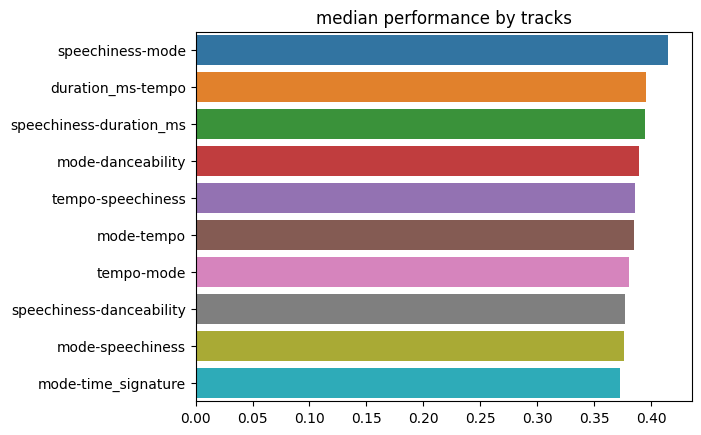

In [31]:
# The top 10 features in terms of their median performance based on tracks.
sns.barplot(x=list(tracks_median.values())[0:10], y=list(tracks_median.keys())[0:10]).set(title='median performance by tracks')

At a glance, the features danceability, mode, tempo, and speechiness all takes the majority of the occurances. Mode in particular, here

[Text(0.5, 1.0, 'median performance by summary')]

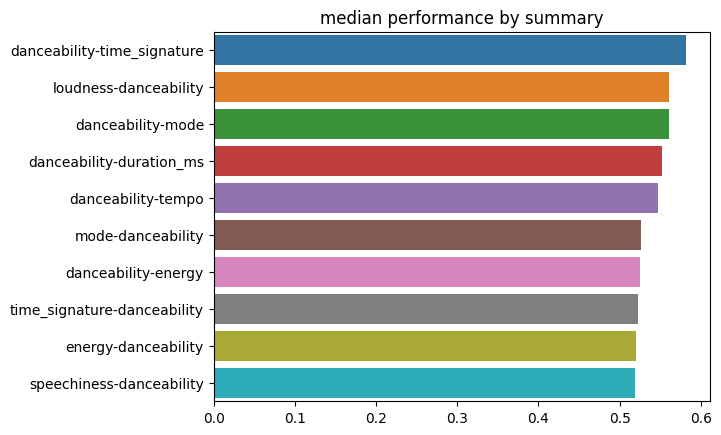

In [32]:
# The top 10 features in terms of their median performance based on summary.
sns.barplot(x=list(summary_median.values())[0:10], y=list(summary_median.keys())[0:10]).set(title='median performance by summary')

At a glance, the features, danceability takes the vast majority of occurances amongt the top 10.
However, this isn't a strong performance--even the best of medians are occuring >50% out.
It's still a reasonable indicator of which features are relatively important--especially
as playlists become more arbitrary, or after they have lost information.
It does show that danceability takes over for mode. Perhaps it is simple a more stable indicator.

In [48]:
# Find overlapping features in terms of their median, best, and worst performaces.
# The top 20 features in each of the categories were selected.
median_overlap = list(set(list(tracks_median.keys())[0:15]) & set(list(summary_median.keys())[0:15]))
median_overlap

['speechiness-danceability',
 'danceability-mode',
 'danceability-duration_ms',
 'mode-danceability']

In [49]:
best_overlap = list(set(list(tracks_best.keys())[0:15]) & set(list(summary_best.keys())[0:15]))
best_overlap

['danceability-tempo',
 'danceability-loudness',
 'danceability-time_signature',
 'danceability-energy',
 'time_signature-speechiness',
 'danceability-mode']

In [50]:
worst_overlap = list(set(list(tracks_worst.keys())[0:15]) & set(list(summary_worst.keys())[0:15]))
worst_overlap

['speechiness-tempo',
 'danceability-duration_ms',
 'time_signature-tempo',
 'mode-speechiness',
 'mode-danceability',
 'mode-tempo']

In [51]:
# We find the features that works well in both best performance and median performance.
best_median_overlap = list(set(median_overlap) & set(best_overlap))
best_median_overlap

['danceability-mode']

In [52]:
# From the features we found above, eliminate the ones that shows up in overlapped worst performaces.
top_features = list(set(best_median_overlap) - set(worst_overlap))
top_features

['danceability-mode']

Based on the top features we found, danceability and mode have the most occurances, which could imply their importance in the recommendation process.

In [38]:
# Get those feature's performance data.
top_features_dict = {'name':[], 'summary_median':[], 'summary_worst':[], 
                     'summary_best':[], 'tracks_median':[], 'tracks_worst':[], 'tracks_best':[]}

for i in top_features:
    top_features_dict['name'].append(i)
    top_features_dict['summary_median'].append(summary_median[i])
    top_features_dict['summary_worst'].append(summary_worst[i])
    top_features_dict['summary_best'].append(summary_best[i])
    top_features_dict['tracks_median'].append(tracks_median[i])
    top_features_dict['tracks_worst'].append(tracks_worst[i])
    top_features_dict['tracks_best'].append(tracks_best[i])

In [39]:
top_features_df = pd.DataFrame(top_features_dict)

<AxesSubplot: xlabel='name'>

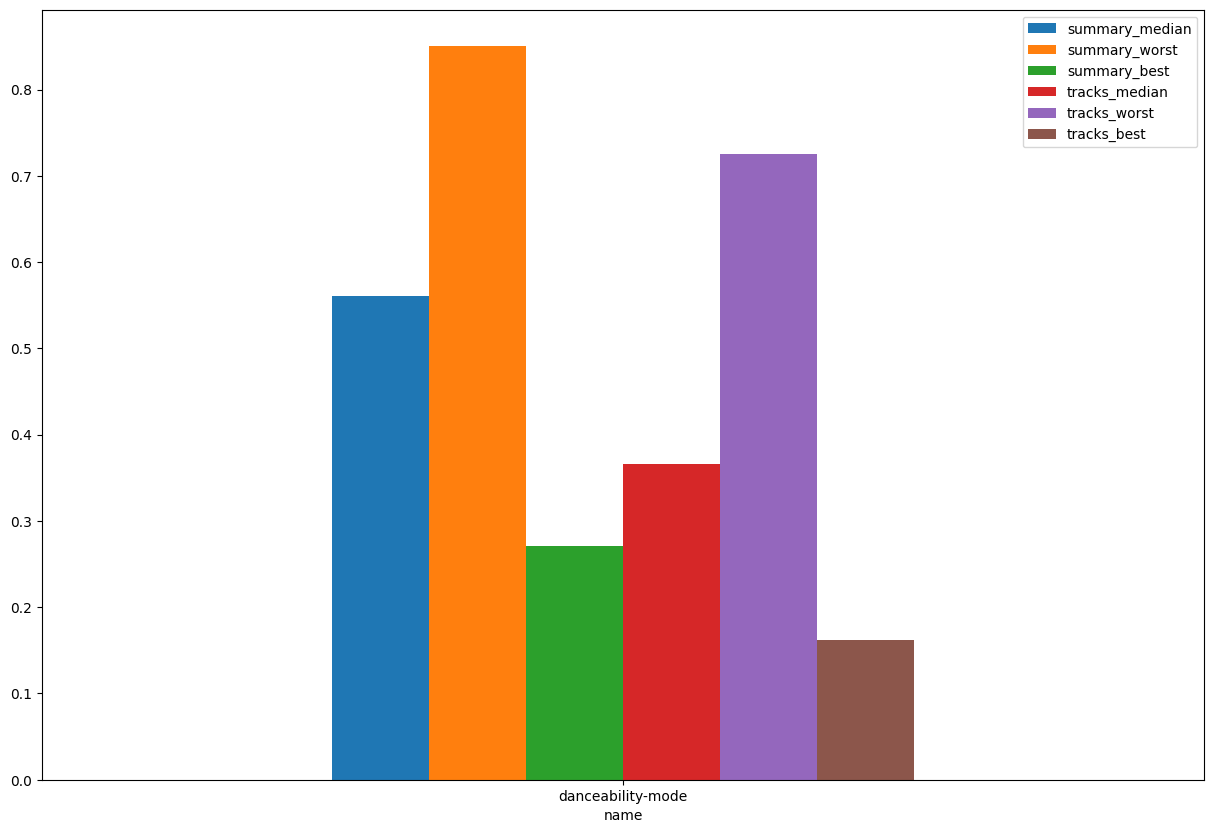

In [40]:
# Plot a side by side bar plot for the top features.
top_features_df.set_index('name').plot.bar(figsize=(15, 10), rot=0)

Next, we examine the performance scores based on the methods used to calculate them.

In [53]:
# We will start with summary first.
# First, we find the features that are the top 20 in terms of their median and best performances.
summary_median_best = list(set(list(summary_median.keys())[0:15]) & set(list(summary_best.keys())[0:15]))
summary_median_best

['danceability-tempo',
 'danceability-loudness',
 'danceability-time_signature',
 'danceability-energy',
 'energy-danceability',
 'loudness-danceability',
 'duration_ms-danceability',
 'tempo-energy',
 'danceability-mode']

In [54]:
# Next, we eliminate the features that also appears in the top 20 worst performances.
top_features_summary = list(set(summary_median_best) - set(list(summary_worst.keys())[0:15]))
top_features_summary

['tempo-energy', 'duration_ms-danceability', 'danceability-energy']

Among the top features in the summary approach, danceability and energy have the most occurances, which could infer their importance.

In [55]:
# Next, we do the same for tracks approach.
tracks_median_best = list(set(list(tracks_median.keys())[0:15]) & set(list(tracks_best.keys())[0:15]))
top_features_tracks = list(set(tracks_median_best) - set(list(tracks_worst.keys())[0:15]))
print(tracks_median_best)
print(top_features_tracks)

['mode-danceability', 'time_signature-speechiness', 'danceability-mode', 'duration_ms-tempo', 'mode-tempo', 'speechiness-mode', 'tempo-mode']
['danceability-mode', 'time_signature-speechiness', 'tempo-mode']


Among the top features in the tracks approach, danceability and time_signature have the most occurances, which could infer their importance.

In [56]:
# Get top summary features' performance data.
top_features_summary_dict = {'name':[], 'summary_median':[], 'summary_worst':[], 
                     'summary_best':[], 'tracks_median':[], 'tracks_worst':[], 'tracks_best':[]}
top_features_tracks_dict = {'name':[], 'summary_median':[], 'summary_worst':[], 
                     'summary_best':[], 'tracks_median':[], 'tracks_worst':[], 'tracks_best':[]}

for i in top_features_summary:
    top_features_summary_dict['name'].append(i)
    top_features_summary_dict['summary_median'].append(summary_median[i])
    top_features_summary_dict['summary_worst'].append(summary_worst[i])
    top_features_summary_dict['summary_best'].append(summary_best[i])
    top_features_summary_dict['tracks_median'].append(tracks_median[i])
    top_features_summary_dict['tracks_worst'].append(tracks_worst[i])
    top_features_summary_dict['tracks_best'].append(tracks_best[i])
    
for i in top_features_tracks:
    top_features_tracks_dict['name'].append(i)
    top_features_tracks_dict['summary_median'].append(summary_median[i])
    top_features_tracks_dict['summary_worst'].append(summary_worst[i])
    top_features_tracks_dict['summary_best'].append(summary_best[i])
    top_features_tracks_dict['tracks_median'].append(tracks_median[i])
    top_features_tracks_dict['tracks_worst'].append(tracks_worst[i])
    top_features_tracks_dict['tracks_best'].append(tracks_best[i])
    
    
# Convert the dictionaries into dataframes.
top_features_summary_df = pd.DataFrame(top_features_summary_dict)
top_features_tracks_df = pd.DataFrame(top_features_tracks_dict)

<AxesSubplot: xlabel='name'>

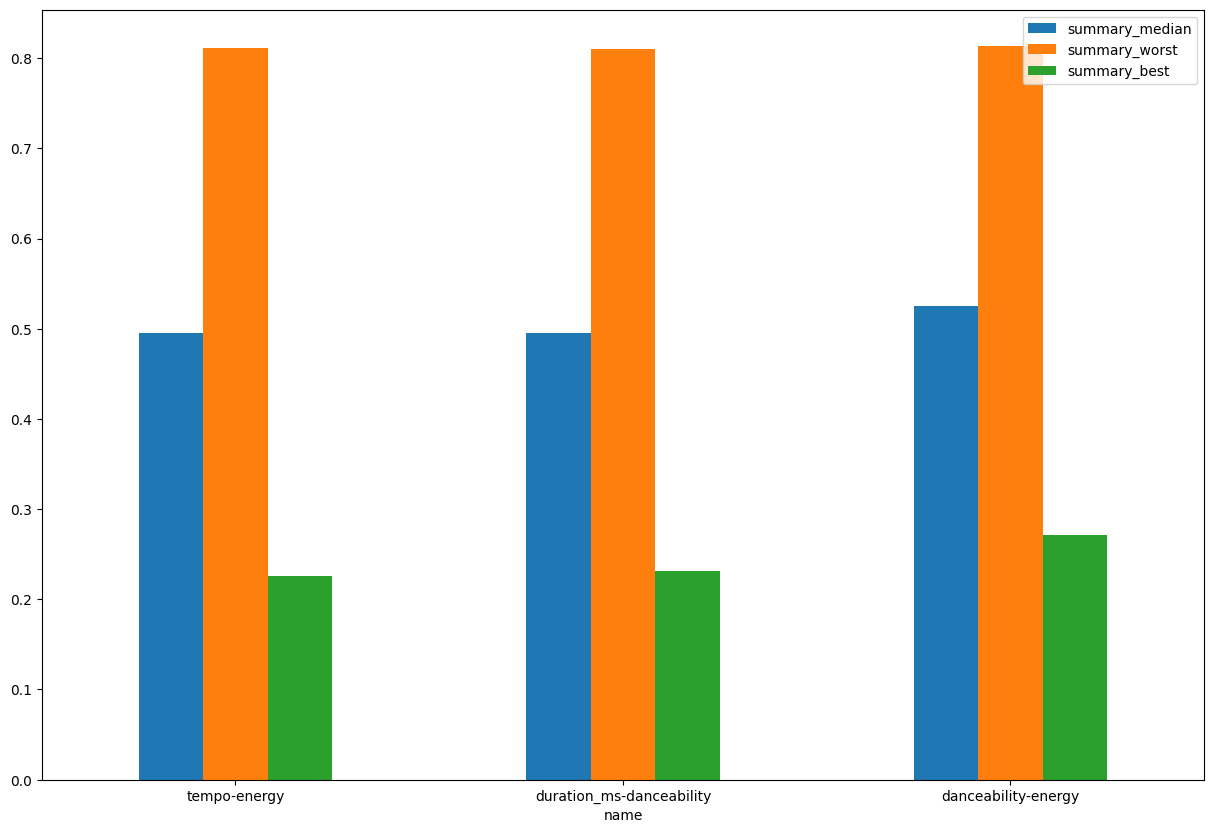

In [57]:
top_features_summary_df[['name', 'summary_median', 
                         'summary_worst', 'summary_best']].set_index('name').plot.bar(figsize=(15, 10), rot=0)

<AxesSubplot: xlabel='name'>

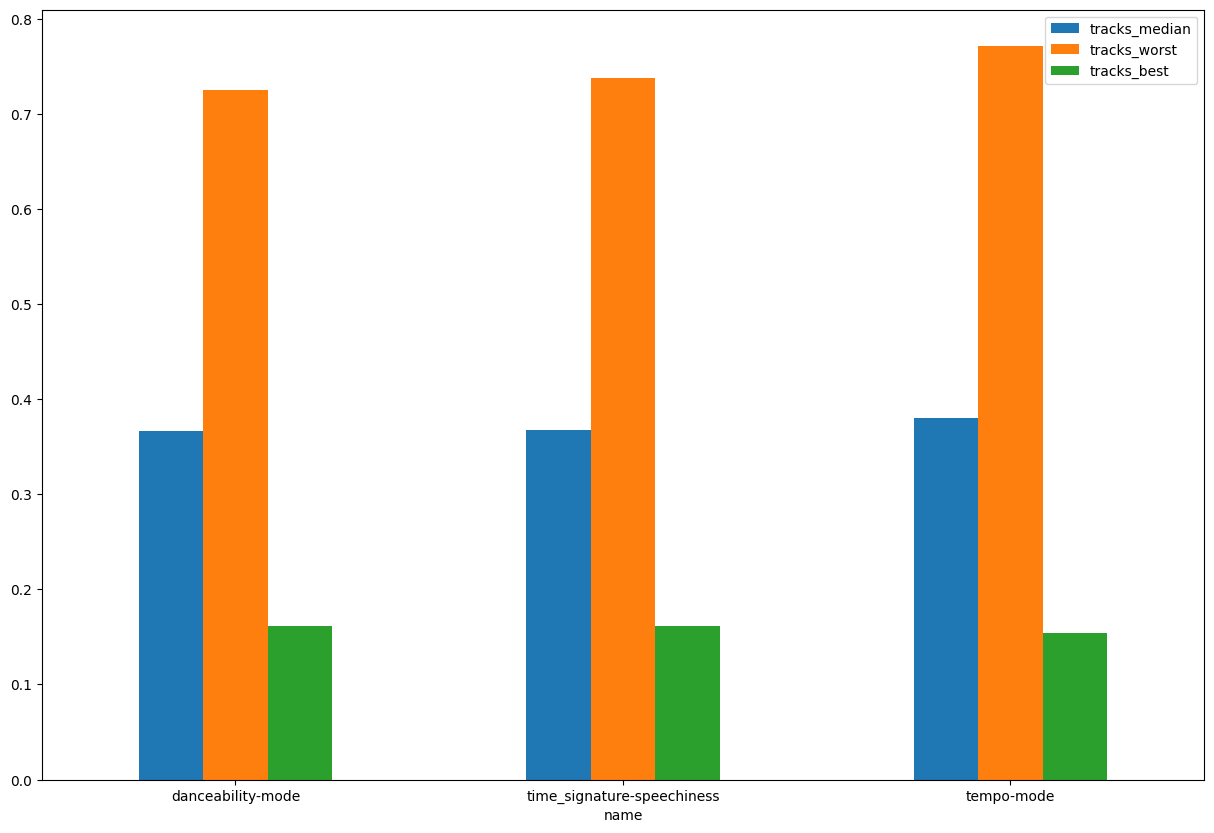

In [58]:
top_features_tracks_df[['name', 'tracks_median', 
                        'tracks_worst', 'tracks_best']].set_index('name').plot.bar(figsize=(15, 10), rot=0)

Based on our findings, the feature "danceability" plays quite an important role in giving out recommendations, as this feature appears not only in the cross analysis of the two performance calculation approaches but also the analysis of the approaches individually. Other features such as time_signature, energy, tempo, and mode also play a significant role in the recommendation process.